In [1]:

import cv2.aruco as aruco
import pickle
import time

In [2]:
# load matrix and distortion from file
cameraMatrix, dist = pickle.load(open("calibration.pkl", "rb"))

In [3]:
import cv2
import cv2.aruco as aruco
import numpy as np

# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 42
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)

proj_marker_image = cv2.aruco.generateImageMarker(aruco_dict, 43, marker_size)


In [4]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [5]:
import time
# add white border to marker image
cv2.destroyAllWindows()

border_size = 2

proj_marker_image = cv2.aruco.generateImageMarker(aruco_dict, 43, marker_size)

proj_marker_image = cv2.copyMakeBorder(proj_marker_image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))





                               
# cv2.imshow("a",proj_marker_image_black_bord)
# cv2.waitKey(1)
# time.sleep(1)
# cv2.destroyAllWindows()

In [6]:

# import required libraries
import cv2
import numpy as np
drawing = False

done = False
ix,iy = -1,-1

rect_corners = None

# define mouse callback function to draw circle
def draw_rectangle(event, x, y, flags, param):
   global ix, iy, drawing, img, done, rect_corners
   if event == cv2.EVENT_LBUTTONDOWN:
      drawing = True
      ix = x
      iy = y

   elif event == cv2.EVENT_LBUTTONUP:
      drawing = False
      cv2.rectangle(img, (ix, iy),(x, y),(0, 255, 255),-1)
      rect_corners = [(ix, iy), (x, y)]
      done = True





# Create a black image
img = np.zeros((1080,1920,3), np.uint8)

# Create a window and bind the function to window
cv2.namedWindow("Rectangle Window", cv2.WND_PROP_FULLSCREEN)

# Connect the mouse button to our callback function
cv2.setMouseCallback("Rectangle Window", draw_rectangle)

# display the window
while True:
   cv2.imshow("Rectangle Window", img)
   if cv2.waitKey(10) == 27:
    break
# if done:
#     time.sleep(5)
    
# cv2.destroyAllWindows()


img = img[:,:,-1]

orig_img = img.copy()

non_zero_indices = np.nonzero(img)

a,b,c,d = non_zero_indices[0].min(), non_zero_indices[0].max(), non_zero_indices[1].min(), non_zero_indices[1].max()
width = d - c
height = b - a

to_place = cv2.resize(proj_marker_image, (width+1, height+1), interpolation=cv2.INTER_AREA)

img[img!=0] = to_place.flatten()

cv2.imshow("Rectangle Window", img)

cv2.waitKey(1)



-1

In [200]:
width, height

(670, 344)

In [9]:
img.shape

(1080, 1920)

In [10]:
img[img!=0].shape

(98582,)

In [11]:
width * height * 3

691440

In [12]:
img_orig = img.copy()

In [13]:
orig_rect_corners = [(rect_corners[0][0], rect_corners[0][1]), (rect_corners[1][0], rect_corners[0][1]), (rect_corners[1][0], rect_corners[1][1]), (rect_corners[0][0], rect_corners[1][1])]

In [14]:
aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)

In [15]:
def rotate_marker_corners(rvec, markersize, tvec = None):

    mhalf = markersize / 2.0
    # convert rot vector to rot matrix both do: markerworld -> cam-world
    mrv, jacobian = cv2.Rodrigues(rvec)

    #in markerworld the corners are all in the xy-plane so z is zero at first
    X = mhalf * mrv[:,0] #rotate the x = mhalf
    Y = mhalf * mrv[:,1] #rotate the y = mhalf
    minusX = X * (-1)
    minusY = Y * (-1)

    # calculate 4 corners of the marker in camworld. corners are enumerated clockwise
    markercorners = []
    markercorners.append(np.add(minusX, Y)) #was upper left in markerworld
    markercorners.append(np.add(X, Y)) #was upper right in markerworld
    markercorners.append(np.add( X, minusY)) #was lower right in markerworld
    markercorners.append(np.add(minusX, minusY)) #was lower left in markerworld
    # if tvec given, move all by tvec
    if tvec is not None:
        C = tvec #center of marker in camworld
        for i, mc in enumerate(markercorners):
            markercorners[i] = np.add(C,mc) #add tvec to each corner
    #print('Vec X, Y, C, dot(X,Y)', X,Y,C, np.dot(X,Y)) # just for debug
    markercorners = np.array(markercorners,dtype=np.float32) # type needed when used as input to cv2
    return markercorners, mrv


In [16]:
def my_estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    '''
    This will estimate the rvec and tvec for each of the marker corners detected by:
       corners, ids, rejectedImgPoints = detector.detectMarkers(image)
    corners - is an array of detected corners for each detected marker in the image
    marker_size - is the size of the detected markers
    mtx - is the camera matrix
    distortion - is the camera distortion matrix
    RETURN list of rvecs, tvecs, and trash (so that it corresponds to the old estimatePoseSingleMarkers())
    '''
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash



In [17]:
orig_proj_corners = np.array(orig_rect_corners) # np.array([[0, 0], [proj_marker_image.shape[1], 0], [proj_marker_image.shape[1], proj_marker_image.shape[0]], [0, proj_marker_image.shape[0]]], dtype=np.float32)
orig_aruco_corners = np.array([[0, 0], [marker_image.shape[1], 0], [marker_image.shape[1], marker_image.shape[0]], [0, marker_image.shape[0]]], dtype=np.float32)
orig_proj_striped_corners = np.array([[0, 0], [proj_marker_image.shape[1], 0], [proj_marker_image.shape[1], proj_marker_image.shape[0]], [0, proj_marker_image.shape[0]]], dtype=np.float32)

In [18]:
ids = []
while ids is None or 43 not in ids or 42 not in ids:
    for i in range(10):
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image")
            break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)

print(ids)

corners_img_proj = corners[np.where(ids == 43)[0].item()]
corners_img_aruco = corners[np.where(ids == 42)[0].item()]

H_proj, _ = cv2.findHomography(orig_proj_corners, corners_img_proj)
H_aruco, _ = cv2.findHomography(orig_aruco_corners, corners_img_aruco)
H_proj_striped, _ = cv2.findHomography(orig_proj_striped_corners, corners_img_proj)

proj_rvecs, proj_tvecs, _ = my_estimatePoseSingleMarkers(corners_img_proj, marker_length, cameraMatrix, dist)
aruco_rvecs, aruco_tvecs, _ = my_estimatePoseSingleMarkers(corners_img_aruco, marker_length, cameraMatrix, dist)

orig_proj_vecs = [proj_rvecs[0], proj_tvecs[0]]
orig_aruco_vecs = [aruco_rvecs[0], aruco_tvecs[0]]

orig_Hs = np.array([H_proj, H_aruco, H_proj_striped])

orig_corners = np.array([orig_proj_corners, orig_aruco_corners])

orig_img_corners = np.array([corners_img_proj, corners_img_aruco])

orig_frame = frame.copy()


[[43]
 [42]]


In [19]:
orig_proj_corners

array([[ 374,  624],
       [1044,  624],
       [1044,  968],
       [ 374,  968]])

In [20]:
orig_proj_striped_corners

array([[  0.,   0.],
       [504.,   0.],
       [504., 504.],
       [  0., 504.]], dtype=float32)

## unwarp projected pattern

In [21]:
img_non_zero_section = img[orig_rect_corners[0][1]:orig_rect_corners[2][1], orig_rect_corners[0][0]:orig_rect_corners[1][0]]

In [22]:
img_non_zero_section_corners = np.array([[0, 0], [img_non_zero_section.shape[1], 0], [img_non_zero_section.shape[1], img_non_zero_section.shape[0]], [0, img_non_zero_section.shape[0]]], dtype=np.float32)

In [23]:
H, _ = cv2.findHomography(corners_img_proj, img_non_zero_section_corners)

In [24]:
img_non_zero_section.shape

(344, 670)

In [25]:
frame_unwarped = cv2.warpPerspective(frame, H,( img_non_zero_section.shape[1], img_non_zero_section.shape[0]))


In [26]:
warped_proj_orig = cv2.warpPerspective(proj_marker_image, orig_Hs[0] , (frame.shape[1], frame.shape[0])) 


In [27]:
frame_unwarped.shape

(344, 670, 3)

In [28]:
import numpy as np
from PIL import Image

def generate_brightness_grid(image_size, patch_size, min_b=0, max_b=255):
    """
    Generate an image divided into patch_size x patch_size blocks,
    where each block gets progressively brighter.

    Args:
        image_size (tuple): (width, height) of the output image
        patch_size (int): size of each square patch

    Returns:
        PIL.Image: Generated grayscale image
    """
    width, height = image_size
    img_array = np.zeros((height, width), dtype=np.uint8)

    num_patches_x = width // patch_size
    num_patches_y = height // patch_size
    total_patches = num_patches_x * num_patches_y

    for y in range(num_patches_y):
        for x in range(num_patches_x):
            patch_index = y * num_patches_x + x
            # brightness = int(255 * patch_index / (total_patches - 1)) if total_patches > 1 else 0
            brightness = int(min_b + (max_b - min_b) * patch_index / (total_patches - 1)) if total_patches > 1 else min_b
            start_x, start_y = x * patch_size, y * patch_size
            img_array[start_y:start_y + patch_size, start_x:start_x + patch_size] = brightness

    return img_array

In [29]:
def plot_on_screen(pimg):
    to_place = cv2.resize(pimg, (width+1, height+1), interpolation=cv2.INTER_AREA)

    color_pattern = orig_img.copy()

    color_pattern = np.expand_dims(color_pattern, axis=-1).repeat(3, axis=-1) 

    color_pattern[color_pattern!=0] = to_place.flatten()

    color_pattern_BGR = cv2.cvtColor(color_pattern, cv2.COLOR_RGB2BGR)

    cv2.imshow("Rectangle Window", color_pattern_BGR)

    key = cv2.waitKey(1)

    if key == ord('q'):
        raise

    time.sleep(1)

In [30]:
import torch
def image_to_patches(image, patch_size, stride):
    """Splits an image tensor into patches.

    Args:
        image (torch.Tensor): Input image tensor (C, H, W).
        patch_size (int): Size of each patch (square).
        stride (int): Stride between patches.

    Returns:
        torch.Tensor: Tensor of patches (N, C, patch_size, patch_size).
    """
    image = torch.tensor(image)
    c, h, w = image.shape
    patches = image.unfold(1, patch_size, stride).unfold(2, patch_size, stride)
    patches = patches.reshape(c, -1, patch_size, patch_size)
    patches = patches.permute(1, 0, 2, 3)
    return patches

def patches_to_image(patches, output_size, patch_size, stride):
    """Combines patches into a single image.

    Args:
        patches (torch.Tensor): Tensor of patches (N, C, patch_size, patch_size).
        output_size (tuple): Size of output image (H, W)
        patch_size (int): Size of each patch (square).
        stride (int): Stride between patches.

    Returns:
        torch.Tensor: Reconstructed image tensor (C, H, W).
    """
    n_patches, c, p_h, p_w = patches.shape
    h, w = output_size
    
    # Initialize output tensor
    output = torch.zeros((c, h, w), device=patches.device)
    
    # Count indicates how many times each pixel has been written to
    counts = torch.zeros((h, w), device=patches.device)
    
    # Calculate number of patches per row/column
    n_h = (h - patch_size) // stride + 1
    n_w = (w - patch_size) // stride + 1
    
    # Place patches into output tensor
    for i in range(n_h):
        for j in range(n_w):
            if i * n_w + j >= n_patches:
                break
            patch_idx = i * n_w + j
            patch = patches[patch_idx]
            y_start = i * stride
            x_start = j * stride
            
            # Add patch values to output
            output[:, y_start:y_start + patch_size, x_start:x_start + patch_size] += patch
            counts[y_start:y_start + patch_size, x_start:x_start + patch_size] += 1
    
    # Average overlapping patches
    output = output / counts.unsqueeze(0).clamp(min=1)
    
    return output

In [31]:
def cap_and_uwarp():
    for i in range(10):
        ret, frame = cap.read()
        time.sleep(0.01)
        if not ret:
            print("Failed to capture image")
            break
    frame_unwarped = cv2.warpPerspective(frame, H,( img_non_zero_section.shape[1], img_non_zero_section.shape[0]))
    frame_unwarped = cv2.cvtColor(frame_unwarped, cv2.COLOR_BGR2RGB)
    return frame_unwarped

In [32]:
brigntness =  [30,50,70,90,110,130,150,170,190,210,230,250]
caps = []
pimgs = []
for channel in range(3):
    for b in brigntness:
        # chorip = generate_brightness_grid((img_non_zero_section.shape[1], img_non_zero_section.shape[0]), 64, b-brigntness[0], b)
        # chorip = np.expand_dims(chorip, axis=-1).repeat(3, axis=-1)
        # pimg = chorip.copy()
        # pimg[:,:,[0]] = 0
        pimg = np.zeros_like(img_non_zero_section, dtype=np.uint8)
        pimg = np.expand_dims(pimg, axis=-1).repeat(3, axis=-1)
        pimg[:,:,[channel]] = b
        plot_on_screen(pimg)
        # for i in range(10):
        #     ret, frame = cap.read()
        #     time.sleep(0.1)
        #     if not ret:
        #         print("Failed to capture image")
        #         break
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame)
        # plt.show()
        unwarped_frames = []
        for i in range(10):
            cur_unwraped = cap_and_uwarp()
            unwarped_frames.append(cur_unwraped)
        unwarped_frames = np.array(unwarped_frames)
        frame_unwarped = np.mean(unwarped_frames, axis=0).astype(np.uint8)
        pimgs.append(pimg)
        caps.append(frame_unwarped)



In [201]:
img_non_zero_section.shape

(344, 670)

In [213]:
len(brigntness)

12

In [33]:
caps = np.array(caps)
pimgs = np.array(pimgs)

In [34]:
import torchvision
tt = torchvision.transforms.ToTensor()
ti = torchvision.transforms.ToPILImage()

In [46]:
tt(caps[0]).shape

torch.Size([3, 344, 670])

In [47]:
np.array(caps[0].shape )/ 5

array([ 68.8, 134. ,   0.6])

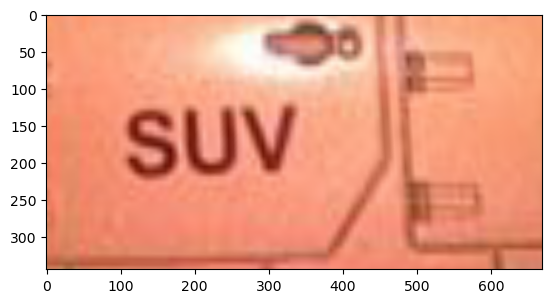

In [48]:
plt.imshow(caps[3])

In [ ]:
resizer = lambda x:x#torchvision.transforms.Resize((int(caps[0].shape[0] / 5), int(caps[0].shape[1] / 5)))
patches_pairs = []
for i in range(len(caps)):
    caps_smaller = resizer(tt(caps[i]))
    pimgs_smaller = resizer(tt(pimgs[i]))
    patches_cap = image_to_patches(caps_smaller, 1, 1)
    patches_pimg = image_to_patches(pimgs_smaller, 1, 1)
    patches_cap = patches_cap.numpy()
    patches_pimg = patches_pimg.numpy()
    patches_pairs.append((patches_pimg,patches_cap))
patches_pairs = np.array(patches_pairs)

patches_pairs = patches_pairs.transpose((2,1,0,3,4,5))

# patches_pairs = patches_pairs.reshape((patches_pairs.shape[0], 2,12, -1))

C:\Users\danny\AppData\Local\Temp\ipykernel_23908\1940788075.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


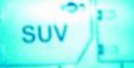

In [157]:
ti(resizer(tt(caps[i])))

In [195]:
caps[i].shape

(344, 670, 3)

In [198]:
pimgs_smaller.shape

torch.Size([3, 344, 670])

In [160]:
patches_pairs.shape

(230480, 2, 36, 3, 1, 1)

In [161]:

# patches_pairs = patches_pairs.reshape((patches_pairs.shape[0], 2,12, 3, -1))

In [162]:
patches_pairs.shape

(230480, 2, 36, 3, 1, 1)

In [163]:
# x = patches_pairs[:,0,...].reshape((patches_pairs.shape[0], -1,1))
# y = patches_pairs[:,1,...].reshape((patches_pairs.shape[0], -1,1))

In [164]:
x = patches_pairs[:,0,:,:,0,0]
y = patches_pairs[:,1,:,:,0,0]

In [165]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
import tqdm
import matplotlib.pyplot as plt
poly = PolynomialFeatures(degree=3)
spline = SplineTransformer(n_knots=8, degree=5)


In [166]:
models = []
preds = []

In [168]:
models = []
preds = []

errors = []
for pixel in tqdm.tqdm(zip(x, y),total=x.shape[0]):

    x_pixel = pixel[0]
    y_pixel = pixel[1]
    spline = SplineTransformer(n_knots=6, degree=6)
    # model = LinearRegression()
    model = make_pipeline(spline, Ridge())
    model.fit(x_pixel, y_pixel)
    y_pred = model.predict(x_pixel)
    models.append(model)
    preds.append(y_pred)
    error = np.mean(np.abs(y_pixel - y_pred))
    errors.append(error)
    if error > 0.1 :
        raise
    
    # plt.plot(x_pixel, y_pixel, 'o', label='data')
    # plt.plot(x_pixel, y_pred, 'r-', label='prediction')
    # plt.legend()
    # plt.show()
    

100%|██████████| 230480/230480 [10:58<00:00, 349.91it/s]


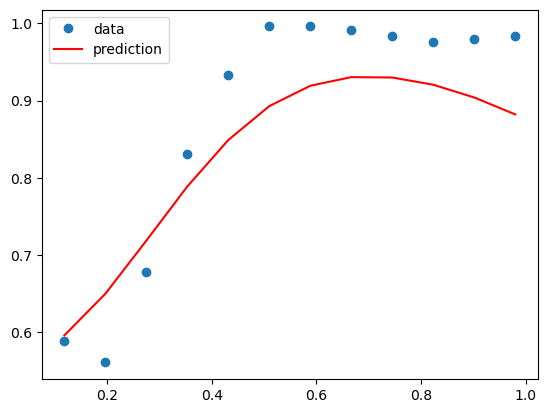

In [169]:
plt.plot(x_pixel[:12,0], y_pixel[:12,0], 'o', label='data')
plt.plot(x_pixel[:12,0], y_pred[:12,0], 'r-', label='prediction')
plt.legend()
plt.show()

In [170]:
errors = np.array(errors)

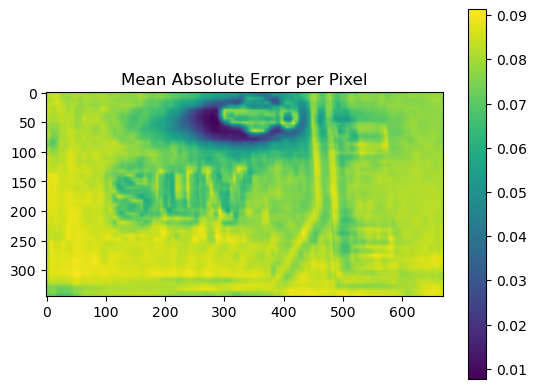

In [214]:
er = errors.reshape((caps_smaller.shape[1],caps_smaller.shape[2]))
plt.imshow(er)
plt.colorbar()
plt.title("Mean Absolute Error per Pixel")
plt.show()


In [569]:
preds = []

for i,pixel in tqdm.tqdm(enumerate(zip(x, y)),total=x.shape[0]):

    x_pixel = pixel[0]
    y_pixel = pixel[1]
    model = models[i]
    y_pred = model.predict(x_pixel)
    preds.append(y_pred)

100%|██████████| 8976/8976 [00:04<00:00, 1818.71it/s]


In [172]:
# y = patches_pairs[::100000,0,24:,2,0,0]
# x = patches_pairs[::100000,1,24:,2,0,0]

In [173]:
preds = np.array(preds)

In [174]:
caps_smaller.shape

torch.Size([3, 344, 670])

In [175]:
preds = preds.reshape((caps_smaller.shape[1],caps_smaller.shape[2], 36,3))
preds = preds.transpose((2,0,1,3))

In [176]:
real = y.reshape((caps_smaller.shape[1],caps_smaller.shape[2], 36,3))
real = real.transpose((2,0,1,3))

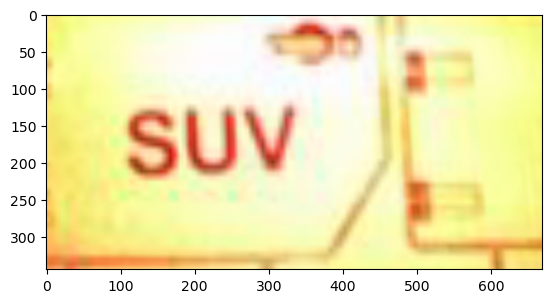

In [234]:
plt.imshow(real[10,...])

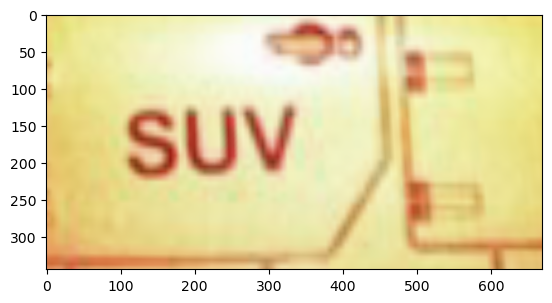

In [235]:
plt.imshow(preds[10,...])

In [229]:
colorful_pattern = tt(cv2.imread('colorful_pattern.jpg'))* 0.5
to_place =  cv2.resize(np.array(ti(colorful_pattern)), (width, height), interpolation=cv2.INTER_AREA) 


In [ ]:
plot_on_screen(to_place)
unwarped_frames = []
time.sleep(4)
for i in range(10):
    cur_unwraped = cap_and_uwarp()
    unwarped_frames.append(cur_unwraped)
unwarped_frames = np.array(unwarped_frames)
frame_unwarped = np.mean(unwarped_frames, axis=0).astype(np.uint8)


In [207]:
to_place.reshape(-1,3).shape[0]== len(models)

True

In [230]:
pixels = resizer(tt(to_place)).permute(1,2,0).reshape((-1, 3)).numpy().astype(np.float32)
pattern_pred = np.zeros_like(pixels, dtype=np.float32)
for i, pixel in enumerate(tqdm.tqdm(pixels, total=pixels.shape[0])):
    x_pixel = pixel.reshape((1, -1))
    model = models[i]
    y_pred = model.predict(x_pixel)
    pattern_pred[i] = y_pred


  0%|          | 0/230480 [00:00<?, ?it/s]

100%|██████████| 230480/230480 [01:28<00:00, 2613.09it/s]


In [231]:
pattern_pred = pattern_pred.reshape((resizer(tt(to_place)).shape[1], resizer(tt(to_place)).shape[2], 3))

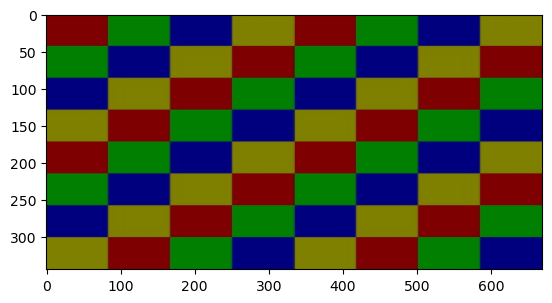

In [232]:
plt.imshow(tt(to_place).permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


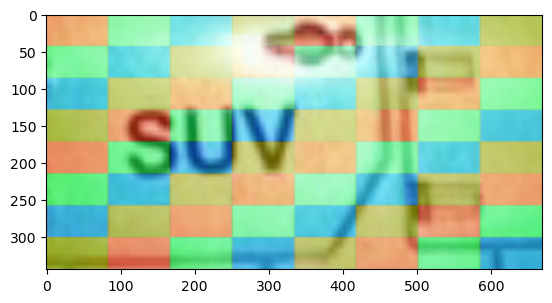

In [233]:
plt.imshow(pattern_pred)

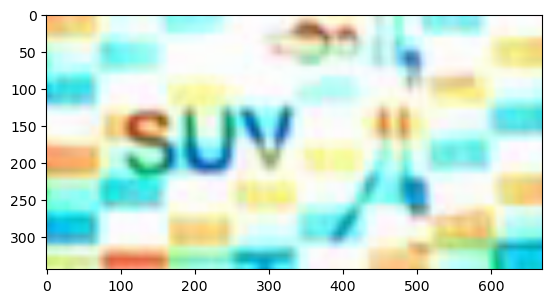

In [221]:
plt.imshow(frame_unwarped)

Text(0.5, 1.0, 'Brightness vs. Color Value')

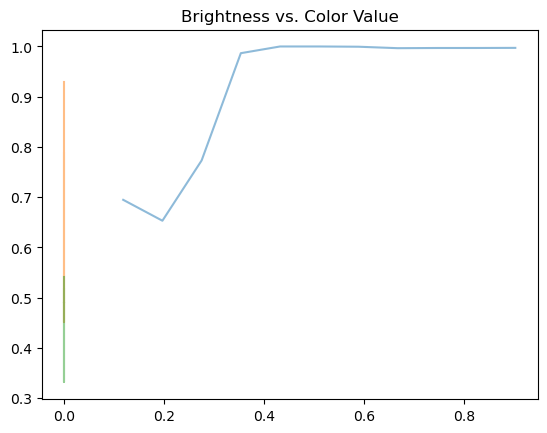

In [75]:
# plot y vs x for each


for xx, yy in zip(x[::1000000,:11,...], y[::1000000,:11,...]):
    plt.plot(xx, yy, alpha=0.5)
    
    xx = xx.reshape(-1, 1)
    yy = yy.reshape(-1, 1)
    # poly_x = poly.fit_transform(xx)
    spline_x = spline.fit_transform(xx)
    model = LinearRegression()
    # model = make_pipeline(SplineTransformer(n_knots=5, degree=3), Ridge(alpha=1e-3))
    model.fit(spline_x, yy)
    y_pred = model.predict(spline_x)
    # plt.plot(xx, y_pred, alpha=0.5, color='red')
    

    # find polynomial fit of degree 2

plt.title('Brightness vs. Color Value')



In [149]:

models = []
preds = []
for patch in tqdm.tqdm(patches_pairs):
    X = patch[0]
    Y = patch[1]
    # X = X.reshape(X.shape[0], -1)
    # Y = Y.reshape(Y.shape[0], -1)
    reg = LinearRegression().fit(X, Y)
    # print("Coefficients:", reg.coef_)
    # print("Intercept:", reg.intercept_)
    # print("Score:", reg.score(X, Y))
    preds.append(reg.predict(X))
    models.append(reg)


100%|██████████| 14784/14784 [00:27<00:00, 540.87it/s]


In [131]:
Y.shape

(12, 48)

In [147]:
models[0].coef_

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [-1.744639 , -4.285956 , 17.184969 , ...,  7.155914 , -2.1185195,
         4.9016466],
       [-1.744639 , -4.285956 , 17.184969 , ...,  7.155914 , -2.1185195,
         4.9016466],
       [-1.744639 , -4.285956 , 17.184969 , ...,  7.155914 , -2.1185195,
         4.9016466]], dtype=float32)

In [140]:
patches = image_to_patches(tt(caps[0]), 5, 5)

C:\Users\danny\AppData\Local\Temp\ipykernel_24088\1940788075.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


In [148]:
patches.shape

torch.Size([9380, 3, 5, 5])

In [141]:
restored = patches_to_image(patches, (caps[0].shape[0], caps[0].shape[1]), 5, 5)

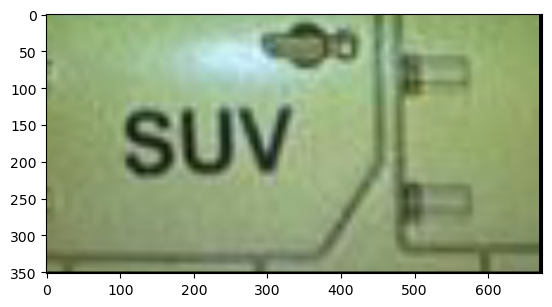

In [142]:
plt.imshow(ti(restored))

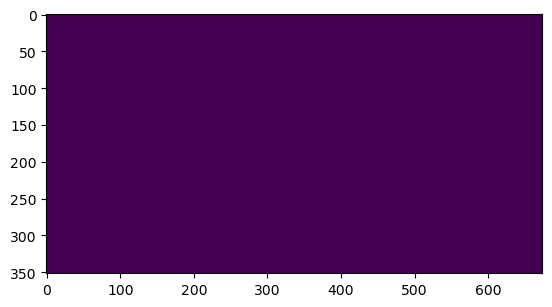

In [ ]:
plt.imshow(pimgs[4][:,:,1])

In [151]:
preds = np.array(preds)

In [155]:
preds = preds.transpose((1, 0, 2))

In [158]:
preds[0].shape

(14784, 48)

In [161]:
res_patch = patches_to_image(torch.tensor(preds[0].reshape(-1,3,4,4)), (caps[0].shape[0], caps[0].shape[1]), 4,4)

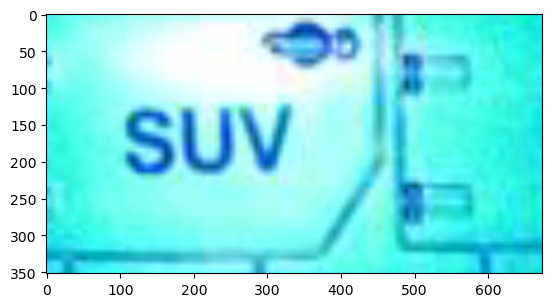

In [169]:
plt.imshow(caps[10][:,:,:])

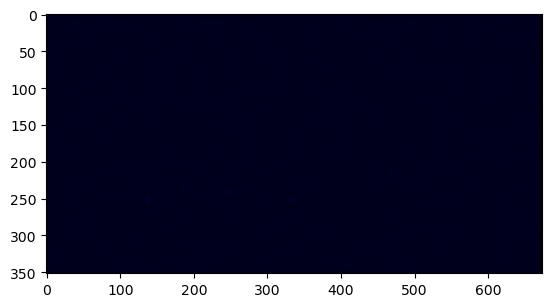

In [163]:
plt.imshow(ti(res_patch))

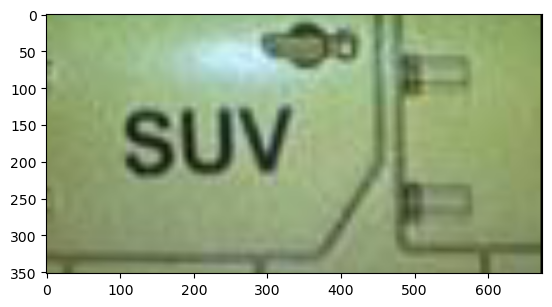

In [74]:
plt.imshow(ti(restored))

In [55]:
patches.shape

torch.Size([18, 3, 100, 100])

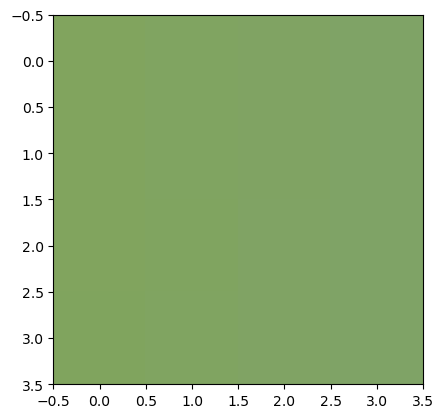

In [75]:
plt.imshow(ti(patches[2]))

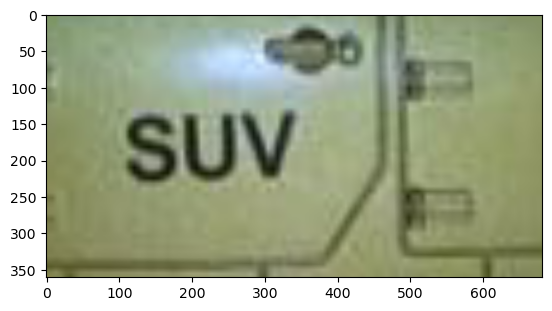

In [68]:
plt.imshow(caps[1])

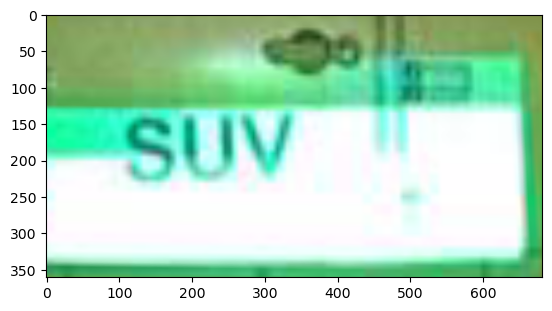

In [34]:
plt.imshow(cap_and_uwarp())

In [ ]:
plt.imshow(frame_unwarped)

In [ ]:
img_non_zero_section_corners

In [ ]:
corners_img_proj

In [ ]:
plt.imshow(frame)

In [ ]:
orig_mapping_H = orig_Hs[0] @ np.linalg.inv(orig_Hs[1])

In [ ]:
orig_mapping_H @ orig_Hs[1]

In [ ]:
orig_Hs[0]

In [ ]:
orig_aruco_corners
# apply homography on orig_aruco_corners
cv2.perspectiveTransform(corners[np.where(ids == 42)[0].item()][0].reshape(-1, 1, 2), np.linalg.inv(H_aruco) ).reshape(-1, 2).astype(np.float16)

In [ ]:
import IPython

In [ ]:

def invert_scale_in_homography(H):
    # Normalize
    H = H / H[2, 2]
    
    # Extract affine part
    A = H[:2, :2]
    
    # SVD decomposition
    U, S_vals, Vt = np.linalg.svd(A)
    
    # Invert scale (keep rotation + shear)
    inverted_S = np.diag(1 / S_vals)
    
    # Rebuild A
    A_new = U @ inverted_S @ Vt
    
    # Replace in H
    H_new = H.copy()
    H_new[:2, :2] = A_new
    
    return H_new

In [ ]:
inv_orig_aruco = np.linalg.inv(orig_Hs[1])
cap_frames =[]
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break
    cap_frames.append(frame.copy())

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)
    # print(ids)

    if ids is not None and 42 in ids:
        # H_proj, _ = cv2.findHomography(orig_proj_corners, corners[np.where(ids == 43)[0].item()][0])
        H_aruco, _ = cv2.findHomography(orig_aruco_corners, corners[np.where(ids == 42)[0].item()][0])

        # cur_corners_img_proj = corners[np.where(ids == 43)[0].item()]
        cur_corners_img_aruco = corners[np.where(ids == 42)[0].item()]


        aruco_rvecs, aruco_tvecs, _ = my_estimatePoseSingleMarkers(corners[np.where(ids == 42)[0].item()], marker_length, cameraMatrix, dist)


        # R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
        # R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

        # R_diff = R_orig @ R_curr.T
        # t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])

        # Draw the detected markers and their axes 
        frame = aruco.drawDetectedMarkers(frame, corners, ids)
        frame = cv2.drawFrameAxes(frame, cameraMatrix, dist, aruco_rvecs[0], aruco_tvecs[0], 0.1)  # Draw axis for the detected marker

        # cv2.putText(frame, f"R_diff: {R_diff}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        # cv2.putText(frame, f"t_diff: {t_diff}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0 , 255), 1)

        cv2.imshow('frame', frame)

        key = cv2.waitKey(1)

        if key == ord('q'):
            break

        # print("R_diff: \n", R_diff)
        # print("t_diff: \n", t_diff)


        # new_corn = cv2.perspectiveTransform(corners[np.where(ids == 42)[0].item()][0].reshape(-1, 1, 2), np.linalg.inv(orig_Hs[1]) ).reshape(-1, 2).astype(np.float16)

        # print("new corners: \n")

        # print(new_corn)

        diff_H =    H_aruco @ inv_orig_aruco

        H_aruco_disp, _ = cv2.findHomography(orig_img_corners[1], corners[np.where(ids == 42)[0].item()][0])

        
        M = find_M(orig_frame,frame)

    

        # corners_img_proj_warped = cv2.perspectiveTransform(corners_img_proj.reshape(-1, 1, 2), M).reshape(-1, 2).astype(np.float16)


        proj_marker_image_rgb = np.expand_dims(img_orig, axis=-1)
        proj_marker_image_rgb = np.repeat(proj_marker_image_rgb, 3, axis=-1)

        warped_proj_orig = cv2.warpPerspective(proj_marker_image_rgb, orig_Hs[0] , (frame.shape[1], frame.shape[0])) 
        warped_proj_orig_mask = cv2.warpPerspective(proj_marker_image_rgb*0+1, orig_Hs[0] , (frame.shape[1], frame.shape[0])) 

        ##############################################################################
        proj_striped_marker_image_rgb = np.expand_dims(proj_marker_image, axis=-1)
        proj_striped_marker_image_rgb = np.repeat(proj_striped_marker_image_rgb, 3, axis=-1)

        warped_proj_orig_striped = cv2.warpPerspective(proj_striped_marker_image_rgb, orig_Hs[2] , (frame.shape[1], frame.shape[0]))
        warped_proj_orig_striped_mask = cv2.warpPerspective(proj_striped_marker_image_rgb*0+1, orig_Hs[2] , (frame.shape[1], frame.shape[0]))

        sum_tensor = (1-warped_proj_orig_striped_mask) * frame + warped_proj_orig_striped
        cv2.imshow("sum_tensor_orig", sum_tensor)

        # M_new = M.copy()
        # M_new[:2,:2] = np.linalg.inv(M[:2,:2])
        M_scale_inv = invert_scale_in_homography(M)
        
        warped_proj = cv2.warpPerspective(warped_proj_orig, M  , (frame.shape[1], frame.shape[0]))
        warped_proj_mask = cv2.warpPerspective(warped_proj_orig_mask, M  , (frame.shape[1], frame.shape[0]))

        warped_proj_striped = cv2.warpPerspective(warped_proj_orig_striped, M  , (frame.shape[1], frame.shape[0]))
        warped_proj_striped_mask = cv2.warpPerspective(warped_proj_orig_striped_mask, M  , (frame.shape[1], frame.shape[0]))


        sum_tensor = (1-warped_proj_striped_mask) * frame + warped_proj_striped

        cv2.imshow("sum_tensor", sum_tensor)
        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        
        
        # time.sleep(0.5)

        # clear the console
        # IPython.display.clear_output(wait=True)

        warped_proj_inv = cv2.warpPerspective(warped_proj, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0]))

        cv2.imshow("Rectangle Window", warped_proj_inv)

        key = cv2.waitKey(1)
        if key == ord('q'):
            break

        orig_center_points = np.array(rect_corners).mean(axis=0).reshape(1, 2).astype(np.float32)[0]
        p = cv2.perspectiveTransform(orig_center_points.reshape(-1, 1, 2), orig_Hs[0]).reshape(-1, 2)
        p = cv2.perspectiveTransform(p.reshape(-1, 1, 2), M).reshape(-1, 2)
        p = cv2.perspectiveTransform(p.reshape(-1, 1, 2), np.linalg.inv(orig_Hs[0])).reshape(-1, 2).astype(np.float32)

        rmat = cv2.getRotationMatrix2D(
            (int(p[:, 0]), int(p[:, 1])), 180, 1
        )
        rotated = cv2.warpAffine(warped_proj_inv, rmat, (warped_proj_inv.shape[1], warped_proj_inv.shape[0]))


        # cv2.imshow("Rectangle Window", warped_proj_inv)



        R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
        R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

        R_diff = R_orig @ np.linalg.inv(R_curr)  

        # t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])
        t_diff = orig_aruco_vecs[1] - aruco_tvecs[0]


        r_diff = cv2.Rodrigues(R_diff)[0]

        print("t_diff: \n", t_diff)

        print("R_diff: \n", R_diff)

        print("r_diff: \n", r_diff)

        # R_2D = R_diff[:2, :2]
        # t_diff = orig_aruco_vecs[1] - aruco_tvecs[0]
        # # Add translation manually if needed
        # tx, ty = t_diff[1][0], t_diff[0][0]
        # M_affine = np.hstack([R_2D, np.array([[0], [0]])])  # shape (2, 3)

        # w,h = frame.shape[1], frame.shape[0]
        # rotated = cv2.warpAffine(warped_proj_orig_striped, M_affine, (w, h))
        # rotated_mask = cv2.warpAffine(warped_proj_orig_striped_mask, M_affine, (w, h))
        # sum_tensor_rotated = (1-rotated_mask) * frame + rotated


        # cv2.imshow("rotated", sum_tensor_rotated)

        # key = cv2.waitKey(1)
        # if key == ord('q'):
        #     break        

        IPython.display.clear_output(wait=True)



In [ ]:
num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(M, cameraMatrix)

In [ ]:
M

In [ ]:
orig_center_points = np.array(rect_corners).mean(axis=0).reshape(1, 2).astype(np.float32)[0]
orig_center_points

In [ ]:
# apply M on the points
p = cv2.perspectiveTransform(orig_center_points.reshape(-1, 1, 2), orig_Hs[0]).reshape(-1, 2)
p = cv2.perspectiveTransform(p.reshape(-1, 1, 2), M).reshape(-1, 2)
p = cv2.perspectiveTransform(p.reshape(-1, 1, 2), np.linalg.inv(orig_Hs[0])).reshape(-1, 2).astype(np.float32)
print("orig_center_points: \n", p)

In [ ]:
orig_center_points

In [ ]:
plt.imshow(proj_marker_image_rgb)
plt.plot(orig_center_points[0], orig_center_points[1], 'ro', markersize=5, label='Original Center Points')

In [ ]:
p[:, 0]

In [ ]:
plt.imshow(warped_proj_inv)
plt.show()
plt.plot(p[:, 0], p[:, 1], 'ro', markersize=5, label='Transformed Points')

rmat = cv2.getRotationMatrix2D(
    (int(p[:, 0]), int(p[:, 1])), 180, 1
)
rotated = cv2.warpAffine(warped_proj_inv, rmat, (warped_proj_inv.shape[1], warped_proj_inv.shape[0]))

plt.imshow(rotated)
plt.show()

In [ ]:
plt.imshow(warped_proj_inv)
plt.show()
# detect aruco markers in the image
warped_proj_inv_gray = cv2.cvtColor(warped_proj_inv, cv2.COLOR_BGR2GRAY)
aruco_corners, aruco_ids, _ = detector.detectMarkers(warped_proj_inv_gray)

# mirrored
plt.imshow(proj_marker_image_rgb)
plt.show()

In [ ]:
tx, ty = t_diff[0][0], t_diff[1][0]
M_affine = np.hstack([R_2D, np.array([[0], [0]])])  # shape (2, 3)

w,h = warped_proj_orig.shape[1], warped_proj_orig.shape[0]
rotated = cv2.warpAffine(warped_proj_orig, M_affine, (w, h))

plt.imshow(proj_striped_marker_image_rgb)

In [ ]:
R_2D = R_diff[:2, :2]
t_diff = orig_aruco_vecs[1] - aruco_tvecs[0]
# Add translation manually if needed
tx, ty = t_diff[0][0], t_diff[1][0]
M_affine = np.hstack([R_2D, np.array([[0], [0]])])  # shape (2, 3)


In [ ]:
w,h = warped_proj_orig.shape[1], warped_proj_orig.shape[0]
rotated = cv2.warpAffine(warped_proj_orig, M_affine, (w, h))

In [ ]:
plt.imshow(rotated)
plt.show()

In [ ]:
r_diff

In [ ]:
M_new = M.copy()
M_new[:2,:2] = np.linalg.inv(M[:2,:2])

In [ ]:
np.linalg.inv(M[:2,:2])

In [ ]:
M_new

In [ ]:
plt.imshow(warped_proj_inv)

In [ ]:
plt.imshow(orig_frame)

In [ ]:
plt.imshow(cap_frames[0])

In [ ]:
sift = cv2.SIFT_create()

def find_M(img1, img2):

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)    

    return M    

In [ ]:
if len(good)>1:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
 
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
 
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), 1) )
    matchesMask = None

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3, 'gray'),plt.show()

In [ ]:
tvec_diff = orig_aruco_vecs[1] - aruco_tvecs

In [ ]:
# apply translation to corners
corners_img_proj = corners[np.where(ids == 43)[0].item()]



In [ ]:
orig_aruco_corners_zerod

In [ ]:
orig_aruco_corners_zerod = np.hstack((orig_aruco_corners, np.zeros((orig_aruco_corners.shape[0], 1))))

In [ ]:

R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

R_diff = R_orig @ np.linalg.inv(R_curr)  

r_diff, _ = cv2.Rodrigues(R_diff)

# t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])
t_diff = orig_aruco_vecs[1] - aruco_tvecs[0]

In [ ]:
R_diff

In [ ]:
orig_aruco_vecs[0] - aruco_rvecs

In [ ]:
r_diff

In [ ]:
orig_proj_vecs

In [ ]:
orig_aruco_vecs

In [ ]:
orig_img_corners[1]

In [ ]:
orig_img_corners[1].mean(1)

In [ ]:
rotate_marker_corners(orig_aruco_vecs[0], marker_length, orig_aruco_vecs[1])[0]

In [ ]:
cv2.projectPoints(orig_aruco_vecs[1], aruco_rvecs[0]*0, aruco_tvecs[0]*0, cameraMatrix, dist)[0]

In [ ]:
cv2.projectPoints(orig_proj_vecs[1], r_diff, t_diff, cameraMatrix, dist)[0]

In [ ]:
cv2.projectPoints(orig_aruco_vecs[1], r_diff, t_diff, cameraMatrix, dist)[0]

In [ ]:
cv2.projectPoints(orig_aruco_vecs[1], aruco_rvecs[0]*0, t_diff, cameraMatrix, dist)[0]

In [ ]:
corners[np.where(ids == 42)[0].item()][0]

In [ ]:
# add coloum of zeros to orig_corners[1]
orig_corn_zerod = np.hstack((orig_corners[1], np.zeros((orig_corners[1].shape[0], 1), dtype=np.float32)))

In [ ]:
pts_3d_transformed = (R_diff @ orig_corn_zerod.T).T + t_diff.T

In [ ]:
rvec_zero = np.zeros((3,1))  # no rotation (because we already applied R_rel)
tvec_zero = np.zeros((3,1))  # no translation (already applied)

imgpts, _ = cv2.projectPoints(pts_3d_transformed, rvec_zero, tvec_zero, cameraMatrix, dist)


In [ ]:
plt.imshow(cv2.warpPerspective(img_orig, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0])))

In [ ]:
orig_mapping_H @ H_aruco_disp 

In [ ]:
plt.imshow(proj_marker_image_rgb)

In [ ]:
orig_mapping_H

In [ ]:
plt.imshow(cv2.warpPerspective(warped_proj_orig, H_aruco_disp, (frame.shape[1], frame.shape[0])))

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
diff_H

In [ ]:
H_aruco_disp

In [ ]:
plt.imshow(img)

In [ ]:
cv2.destroyAllWindows()

In [ ]:
warped_proj_inv = cv2.warpPerspective(warped_proj, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0]))

In [ ]:
cv2.imshow("a", proj_marker_image_black_bord)

cv2.waitKey(1)





In [ ]:
cv2.imshow("a", warped_proj_inv)

cv2.waitKey(1)





In [ ]:
cv2.destroyAllWindows()

In [ ]:
plt.imshow(proj_marker_image)

In [ ]:
warped_proj_orig_mask.shape

In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
plt.imshow(cv2.warpPerspective(warped_proj_orig*0+1, diff_H, (frame.shape[1], frame.shape[0])))

In [ ]:
    frame = aruco.drawDetectedMarkers(frame, corners, ids)


    dst_pts = corners[0][0]
    H, _ = cv2.findHomography(orig_aruco_corners, dst_pts, cv2.RANSAC)
    warp_img = cv2.warpPerspective(proj_marker_image, H, (frame.shape[1], frame.shape[0]))
    warp_mask = cv2.warpPerspective(proj_marker_image*0+1, H, (frame.shape[1], frame.shape[0]))
    sum_tensor = frame * (1 - warp_mask) + warp_img * warp_mask

In [ ]:
# apply t_diff on proj_marker_image


In [ ]:
corn_diff= new_corn - orig_aruco_corners 

In [ ]:
corn_diff

In [ ]:
orig_proj_corners

In [ ]:
ids

In [ ]:
R_diff

In [ ]:
aruco_tvecs

In [ ]:
diff_H =   H_aruco @ np.linalg.inv(orig_Hs[1])

In [ ]:
warped_proj_orig = cv2.warpPerspective(proj_marker_image, orig_Hs[0], (frame.shape[1], frame.shape[0]))


In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
warped_proj = cv2.warpPerspective(warped_proj_orig, diff_H, (frame.shape[1], frame.shape[0]))
# warped_proj_mask = cv2.warpPerspective(warped_proj_orig*0+0.001, diff_H, (frame.shape[1], frame.shape[0]))
warped_proj_mask = (warped_proj != 0).astype(np.uint8) 

warped_proj_mask = np.expand_dims(warped_proj_mask, axis=-1)

sum_tensor = (1-warped_proj_mask) * frame
plt.imshow(sum_tensor)

In [ ]:
frame * (1 - warped_proj_mask)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
A = H_aruco @ np.linalg.inv(orig_Hs[1])

In [ ]:
np.linalg.inv(orig_Hs[1]) @ H_aruco 

In [ ]:
A @ orig_Hs[0]

In [ ]:
plt.imshow(frame)

In [ ]:
warped_proj = cv2.warpPerspective(proj_marker_image, A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))
warped_proj_mask = cv2.warpPerspective(np.ones(proj_marker_image.shape, dtype=np.uint8), A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))

In [ ]:
wrapped_proj_rgb.shape

In [ ]:
wrapped_proj_rgb = cv2.cvtColor(warped_proj, cv2.COLOR_GRAY2RGB)

wrapped_proj_mask_rgb = cv2.cvtColor(warped_proj_mask, cv2.COLOR_GRAY2RGB)


plt.imshow(wrapped_proj_rgb+frame*(1-wrapped_proj_mask_rgb))
plt.show()

In [ ]:
m = cv2.warpPerspective(proj_marker_image,  A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))

In [ ]:
plt.imshow(m)

In [ ]:
marker_image_bord = cv2.copyMakeBorder(warped_proj, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))
cv2.imshow("a",cv2.resize(marker_image_bord,(600,300)))
cv2.waitKey(1)
time.sleep(10)